# Index

 * [Importing stuff](#importing) 
 * [Data scraping and cleaning](#scraping)
 * [Getting Venues data](#getting_venues)
 * [Checkpoint](#checkpoint_1)
 * [Clustering](#clustering)
 * [Work in Progress](#wip)


<a id='importing'></a>

# Importing everything we need

In [1]:
import pandas as pd
import numpy as np
import bs4 as bs
import requests
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics

Solving environment: ...working... done

# All requested packages already installed.



<a id='scraping'></a>

# Data Scraping and cleaning
## Getting data about the neighborhoods such as name and location

In [2]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Belo_Horizonte'
WikiBH = requests.get(url).content
soup = bs.BeautifulSoup(WikiBH,'html.parser')     

In [3]:
data = []
for item in range(len(soup.find_all('tbody')[3].find_all('tr'))):
    row=[]
    if item >0:
        for row_item in range(len(soup.find_all('tbody')[3].find_all('tr')[1].find_all('td'))):
            row.append(soup.find_all('tbody')[3].find_all('tr')[item].find_all('td')[row_item].get_text())
    data.append(row)

df = pd.DataFrame(data,columns=['#','Zone','Regional','Neighborhood','Population','Size(km²)'])
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,#,Zone,Regional,Neighborhood,Population,Size(km²)
0,1,ZONA LESTE,Leste,Sagrada Família,34 395,"2,291\n"
1,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n"
2,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n"
3,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n"
4,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n"
...,...,...,...,...,...,...
498,483,ZONA LESTE,Nordeste,Guanabara,0,"0,002\n"
499,484,ZONA NORTE,Pampulha,Lagoa da Pampulha,0,"3,138\n"
500,485,ZONA NORTE,Noroeste,Sumaré,0,"0,149\n"
501,486,ZONA LESTE,Leste,Vila Vera Cruz I,0,"0,008\n"


In [4]:
df['latitude']=0.0
df['longitude']=0.0
for i in range(len(df['Neighborhood'])):
    address = df['Neighborhood'][i] +', Belo Horizonte'                                
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.  {}'.format(address,latitude, longitude,i))
        df['latitude'][i]=latitude
        df['longitude'][i]=longitude
    else:
        print(df['Neighborhood'][i] + ' wasn\'t found on Nominatim')
        df['latitude'][i]=''
        df['longitude'][i]=''

The geograpical coordinate of Sagrada Família, Belo Horizonte are -20.1964041, -44.1078058.  0


<ipython-input-4-123152a0de33>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'][i]=latitude
<ipython-input-4-123152a0de33>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'][i]=longitude


The geograpical coordinate of Buritis, Belo Horizonte are -19.9765791, -43.9674165.  1
The geograpical coordinate of Padre Eustáquio, Belo Horizonte are -19.9143045, -43.97935599013762.  2
The geograpical coordinate of Lindéia, Belo Horizonte are -19.9774137, -44.0506354.  3
The geograpical coordinate of Santa Mônica, Belo Horizonte are -19.8245686, -43.977456.  4
The geograpical coordinate of Céu Azul, Belo Horizonte are -19.8227499, -44.0039799.  5
The geograpical coordinate of Santa Cruz (ZN), Belo Horizonte are -20.1377829, -44.2008425.  6
The geograpical coordinate of Santa Cruz (ZL), Belo Horizonte are -20.1377829, -44.2008425.  7
The geograpical coordinate of Santo Antônio, Belo Horizonte are -19.4755851, -44.2603603.  8
The geograpical coordinate of Alto Vera Cruz, Belo Horizonte are -19.9110402, -43.8915918.  9
The geograpical coordinate of Jardim dos Comerciários, Belo Horizonte are -19.7927251, -43.9720853.  10
The geograpical coordinate of Piratininga, Belo Horizonte are -1

The geograpical coordinate of Itapoã, Belo Horizonte are -19.8385689, -43.9554151.  89
The geograpical coordinate of Jardim Leblon, Belo Horizonte are -19.8236179, -43.9913595.  90
The geograpical coordinate of Cachoeirinha, Belo Horizonte are -19.8902003, -43.9474556.  91
The geograpical coordinate of Bairro das Indústrias I, Belo Horizonte are -19.963364, -44.0029681.  92
The geograpical coordinate of Santa Inês, Belo Horizonte are -19.8903311, -43.9096812.  93
The geograpical coordinate of Lagoa, Belo Horizonte are -19.8088758, -44.0001975.  94
The geograpical coordinate of São Bernardo, Belo Horizonte are -19.8449229, -43.941626.  95
The geograpical coordinate of Renascença, Belo Horizonte are -19.8912995, -43.9417132.  96
The geograpical coordinate of Dona Clara, Belo Horizonte are -19.859062, -43.942463.  97
The geograpical coordinate of Funcionários, Belo Horizonte are -19.932516200000002, -43.92731827346328.  98
The geograpical coordinate of Belvedere, Belo Horizonte are -19.97

<ipython-input-4-123152a0de33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'][i]=''
C:\Users\lucas\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-4-123152a0de33>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'][i]=''


The geograpical coordinate of Horto Florestal, Belo Horizonte are -19.89546035, -43.91695737553633.  156
The geograpical coordinate of Jardim Montanhês, Belo Horizonte are -19.9051254, -43.9821385.  157
The geograpical coordinate of Juliana, Belo Horizonte are -19.8151, -43.9439193.  158
The geograpical coordinate of São Salvador, Belo Horizonte are -19.8939304, -44.0133336.  159
The geograpical coordinate of Coração de Jesus, Belo Horizonte are -19.945874099999997, -43.95122862577084.  160
The geograpical coordinate of Silveira, Belo Horizonte are -19.8917944, -43.9299132.  161
The geograpical coordinate of Olaria, Belo Horizonte are -19.9908908, -44.0277945.  162
The geograpical coordinate of Pompéia, Belo Horizonte are -19.9096481, -43.9024279.  163
The geograpical coordinate of Vila CEMIG, Belo Horizonte are -19.995432800000003, -43.992366573805114.  164
The geograpical coordinate of Nova Cintra, Belo Horizonte are -19.9480576, -43.9900717.  165
The geograpical coordinate of Castan

The geograpical coordinate of Barroca, Belo Horizonte are -19.931433, -43.9635526.  242
The geograpical coordinate of Dom Joaquim, Belo Horizonte are -19.8781302, -43.9188798.  243
The geograpical coordinate of Pirajá, Belo Horizonte are -19.8659435, -43.9170773.  244
The geograpical coordinate of Conjunto Paulo VI, Belo Horizonte are -19.8314739, -43.8865391138505.  245
The geograpical coordinate of Alto dos Pinheiros, Belo Horizonte are -19.9325674, -44.004875.  246
The geograpical coordinate of Parque São José, Belo Horizonte are -19.9625893, -43.9779282.  247
The geograpical coordinate of Vila Califórnia, Belo Horizonte are -19.9189875, -44.00829.  248
The geograpical coordinate of Novo Tupi, Belo Horizonte are -19.8306232, -43.9048449.  249
The geograpical coordinate of Vila Independência I, Belo Horizonte are -29.5821991, -51.8229041.  250
The geograpical coordinate of Conjunto Jardim Filadélfia, Belo Horizonte are -19.9107907, -44.007685.  251
The geograpical coordinate of São L

The geograpical coordinate of Olhos d'água, Belo Horizonte are -19.9900458, -43.9631249.  328
The geograpical coordinate of Vila Coqueiral, Belo Horizonte are -19.9152291, -44.0247224.  329
The geograpical coordinate of Cidade Jardim, Belo Horizonte are -19.8766162, -43.6567339.  330
The geograpical coordinate of Vila Trinta e Um de Março, Belo Horizonte are -19.9204149, -44.0009698.  331
The geograpical coordinate of São José, Belo Horizonte are -19.8602115, -43.9656973.  332
The geograpical coordinate of Solimões, Belo Horizonte are -4.3941661, -69.8154378.  333
The geograpical coordinate of Bernadete, Belo Horizonte are -19.985184099999998, -43.98424361198627.  334
The geograpical coordinate of Xodó-Marize, Belo Horizonte are -19.821801649999998, -43.94017477200708.  335
The geograpical coordinate of Vila da Luz, Belo Horizonte are -19.856027349999998, -43.89516383118321.  336
The geograpical coordinate of Jardim Atlântico, Belo Horizonte are -19.8482167, -43.9788898.  337
The geogr

The geograpical coordinate of Novo Ouro Preto, Belo Horizonte are -19.8841449, -43.9843336.  411
The geograpical coordinate of Canadá, Belo Horizonte are -19.896521200000002, -43.94491367052375.  412
The geograpical coordinate of Antônio Ribeiro de Abreu, Belo Horizonte are -19.8314454, -43.8997695.  413
The geograpical coordinate of Satélite, Belo Horizonte are -19.8129804, -43.9481047.  414
The geograpical coordinate of Vila Antena Montanhês, Belo Horizonte are -19.8963971, -43.9859864.  415
The geograpical coordinate of Grotinha, Belo Horizonte are -19.85051765, -43.89231111805725.  416
The geograpical coordinate of Cônego Pinheiro, Belo Horizonte are -19.919032950000002, -43.90940352446526.  417
The geograpical coordinate of Chácara Leonina, Belo Horizonte are -19.954873749999997, -43.96042496060794.  418
The geograpical coordinate of Vila Madre Gertrudes III, Belo Horizonte are -19.9769783, -44.0185469.  419
The geograpical coordinate of Vila São Gabriel, Belo Horizonte are -19.84

The geograpical coordinate of Campus UFMG, Belo Horizonte are -19.8679746, -43.9644274.  497
The geograpical coordinate of Guanabara, Belo Horizonte are -19.9701771, -44.1376229.  498
The geograpical coordinate of Lagoa da Pampulha, Belo Horizonte are -19.8533828, -43.97478514927906.  499
The geograpical coordinate of Sumaré, Belo Horizonte are -19.8875873, -43.9654843.  500
Vila Vera Cruz I wasn't found on Nominatim
Vila Vera Cruz II wasn't found on Nominatim


In [5]:
df.drop(df[df['latitude']==''].index,inplace=True)
df.reset_index(drop=True,inplace=True)
df

,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude
0,1,ZONA LESTE,Leste,Sagrada Família,34 395,"2,291\n",-20.1964,-44.1078
1,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n",-19.9766,-43.9674
2,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n",-19.9143,-43.9794
3,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n",-19.9774,-44.0506
4,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n",-19.8246,-43.9775
...,...,...,...,...,...,...,...,...
480,481,ZONA NORTE,Pampulha,Bispo de Maura,0,"0,017\n",-19.8281,-44.0164
481,482,ZONA NORTE,Pampulha,Campus UFMG,0,"3,85\n",-19.868,-43.9644
482,483,ZONA LESTE,Nordeste,Guanabara,0,"0,002\n",-19.9702,-44.1376
483,484,ZONA NORTE,Pampulha,Lagoa da Pampulha,0,"3,138\n",-19.8534,-43.9748


In [3]:
# create map of New York using latitude and longitude values
address = 'Belo Horizonte, MG'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_BH = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Zone'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BH)  
    
map_BH

In [12]:
# Cleaning the data to remove points outside of the city
df = df[(df['longitude'].astype(float)<-43.85) & (df['longitude'].astype(float)>-44.07)
 & (df['latitude'].astype(float)<-19.82) & (df['latitude'].astype(float)>-20) ].reset_index(drop=True,inplace=True)
#Saving to a csv file to make my life easier. If needed I can open the df from the file instead of srapping everything again
df.to_csv('BH_df.csv')

AttributeError: 'NoneType' object has no attribute 'to_csv'

<a id='getting_venues'></a>

# Getting data about venues on Foursquare

In [2]:
CLIENT_ID = 'UOSOUPHZSZ31RZYIACFNWILJ4U1E4HJPT51BGJEXQUKCUJSW' # your Foursquare ID
CLIENT_SECRET = 'ZRXAYW4AVLVJAOAOQP3QS2M1CLFUF5SGCLB5GUQYAM10R2MG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UOSOUPHZSZ31RZYIACFNWILJ4U1E4HJPT51BGJEXQUKCUJSW
CLIENT_SECRET:ZRXAYW4AVLVJAOAOQP3QS2M1CLFUF5SGCLB5GUQYAM10R2MG


In [4]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            #print(results)
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                v['venue']['name'],
                v['venue']['id'],
                #requests.get('https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format(v['venue']['id'], CLIENT_ID, CLIENT_SECRET, VERSION)).json()['response']['venue']['likes']['count'],
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            print(venues_list)
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                                     'Neighborhood Latitude', 
                                     'Neighborhood Longitude', 
                                     'Venue',
                                     'Venue id',
                                     #'Venue likes',
                                     'Venue Latitude', 
                                     'Venue Longitude', 
                                     'Venue Category']
        except:
            print(requests.get(url).json()['meta']['errorType'])
            return(nearby_venues) 
   
    return(nearby_venues)

In [10]:
BH_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['latitude'],longitudes=df['longitude'])
BH_venues

Buritis
[[('Buritis', -19.976579100000002, -43.9674165, "Dog's Shop", '4dcc3ac452b19dd12dcd0670', 34, -19.97430865584377, -43.967688131527076, 'Pet Store'), ('Buritis', -19.976579100000002, -43.9674165, 'Beb’s Bar Buritis', '5b5295ab0802d400399a170b', 9, -19.972796134923563, -43.96724354880272, 'Bar'), ('Buritis', -19.976579100000002, -43.9674165, 'Parque Aggeo Pio Sobrinho', '4c8b19601556bfb7beccff92', 95, -19.976082422386007, -43.970962119551494, 'Park'), ('Buritis', -19.976579100000002, -43.9674165, 'Ponto Da Esfiha Buritis', '4fe35de9e4b0fcbc93110077', 7, -19.975086329860265, -43.96763354892419, 'Fast Food Restaurant'), ('Buritis', -19.976579100000002, -43.9674165, 'Shopping Frutas Buritis', '4d10b48659606dcb86ff763e', 15, -19.976044238898904, -43.97022675934453, 'Fruit & Vegetable Store'), ('Buritis', -19.976579100000002, -43.9674165, 'Shell Select', '4f099e0ae4b071c576b1bec4', 9, -19.973619389996266, -43.96601356804468, 'Convenience Store'), ('Buritis', -19.976579100000002, -43.9

KeyError: 'errorType'

In [ ]:
BH_venues.to_csv('BH_venues.csv')

<a id='checkpoint_1'></a>

# Checkpoint to make my life easier

In [16]:
# Read from csv so I don't have to scrape everything. Had trouble with the Foursquare limit while developing some functions
df = pd.read_csv('BH_df.csv')
BH_venues = pd.read_csv('BH_venues.csv')

<a id='clustering'></a>

# Clustering

In [1]:
# one hot encoding
BH_onehot = pd.get_dummies(BH_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BH_onehot['Neighborhood'] = BH_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [BH_onehot.columns[-1]] + list(BH_onehot.columns[:-1])
BH_onehot = BH_onehot[fixed_columns]

BH_onehot.head()

NameError: name 'pd' is not defined

In [6]:
BH_grouped = BH_onehot.groupby('Neighborhood').mean().reset_index()
BH_grouped

,Neighborhood,Yoga Studio,ATM,Acai House,Accessories Store,Airport Lounge,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,...,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Aarão Reis,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,Acaba Mundo,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,Acaiaca,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,Ademar Maldonado,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Aeroporto,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Xangri-lá,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
360,Xodó-Marize,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
361,Álvaro Camargos,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667
362,Ápia,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [7]:
fixed_columns = [BH_onehot.columns[-1]] + list(BH_onehot.columns[:-1])
BH_onehot = BH_onehot[fixed_columns]

In [8]:
num_top_venues = 5

for hood in BH_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = BH_grouped[BH_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

0.10
2  Dessert Shop  0.10
3   Supermarket  0.10
4     BBQ Joint  0.05


----Tirol----
                  venue  freq
0                Bakery  0.22
1  Gym / Fitness Center  0.13
2                   Bar  0.04
3        Ice Cream Shop  0.04
4        Clothing Store  0.04


----Trevo----
                  venue  freq
0                Bakery  0.25
1                Market  0.25
2  Gym / Fitness Center  0.25
3          Soccer Field  0.25
4      Pedestrian Plaza  0.00


----Três Marias----
                     venue  freq
0     Brazilian Restaurant  0.12
1               Steakhouse  0.12
2             Burger Joint  0.12
3                    Diner  0.12
4  Fruit & Vegetable Store  0.12


----Tupi A----
                    venue  freq
0                  Bakery  0.25
1       Convenience Store  0.17
2          Ice Cream Shop  0.17
3  Furniture / Home Store  0.08
4             Supermarket  0.08


----Tupi B----
                    venue  freq
0                  Bakery  0.21
1       Convenience Store  

In [9]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [10]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BH_grouped['Neighborhood']

for ind in np.arange(BH_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BH_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarão Reis,Ice Cream Shop,Bar,Bakery,Burger Joint,Pub,Park,Gym,Gym / Fitness Center,Supermarket,Restaurant
1,Acaba Mundo,Plaza,Racecourse,Food Truck,Comfort Food Restaurant,Snack Place,Women's Store,Fast Food Restaurant,Event Space,Fair,Farm
2,Acaiaca,Pizza Place,Bakery,Pharmacy,Juice Bar,IT Services,Gym / Fitness Center,Motorcycle Shop,Soccer Field,Snack Place,Fruit & Vegetable Store
3,Ademar Maldonado,Plaza,Bar,Bakery,Fast Food Restaurant,Sushi Restaurant,Ice Cream Shop,Pizza Place,Pet Store,Paper / Office Supplies Store,Soccer Field
4,Aeroporto,Office,Boutique,Food Truck,Water Park,Gym / Fitness Center,Event Space,Fair,Farm,Farmers Market,Fast Food Restaurant


In [14]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

BH_grouped_clustering = BH_grouped.drop('Neighborhood', 1)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(BH_grouped_clustering)
    kmeanModel.fit(BH_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(BH_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / BH_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(BH_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / BH_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [15]:

for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.2683079083749537
2 : 0.2606533102534128
3 : 0.25738574795037733
4 : 0.2527230110104449
5 : 0.2516112312309799
6 : 0.24781039628909746
7 : 0.2467391947334712
8 : 0.24434817606591466
9 : 0.24030405438887464


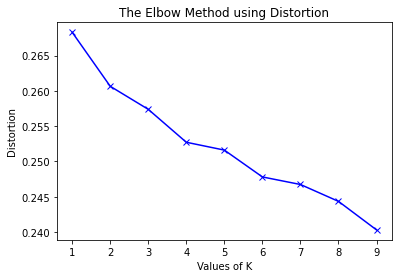

In [16]:

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

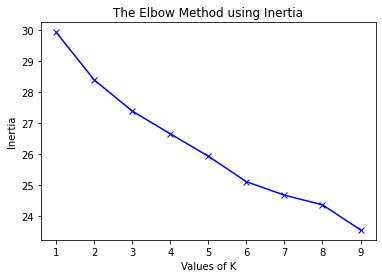

In [17]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [18]:
# set number of clusters
kclusters = 6

BH_grouped_clustering = BH_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 4, 0, 5, 0, 0, 3, 5, 0, 3])

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

BH_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
BH_merged = BH_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

BH_merged.head() # check the last columns!

,Unnamed: 0,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n",-19.976579,-43.967416,0.0,Gym / Fitness Center,Pharmacy,Pet Store,Park,Ice Cream Shop,Fruit & Vegetable Store,Fast Food Restaurant,Supermarket,Scenic Lookout,Lottery Retailer
1,1,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n",-19.914305,-43.979356,5.0,Brazilian Restaurant,Pizza Place,Paper / Office Supplies Store,Bar,Soccer Field,Gym / Fitness Center,Ice Cream Shop,Pharmacy,Restaurant,Acai House
2,2,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n",-19.977414,-44.050635,1.0,Bakery,Pharmacy,Clothing Store,Burger Joint,Supermarket,Women's Store,BBQ Joint,Plaza,Department Store,Pizza Place
3,3,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n",-19.824569,-43.977456,5.0,Burger Joint,Bar,Plaza,Brazilian Restaurant,Hot Dog Joint,Pastry Shop,Boutique,Soccer Field,Snack Place,Fish Market
4,4,6,ZONA NORTE,Pampulha,Céu Azul,23 817,"2,748\n",-19.822750,-44.003980,1.0,Bakery,Soccer Field,Food Truck,Pizza Place,Music Store,Spa,Pet Store,Health & Beauty Service,Grocery Store,Dessert Shop


In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BH_merged['latitude'], BH_merged['longitude'], BH_merged['Neighborhood'], BH_merged[BH_merged['Cluster Labels']<=4]['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
BH_merged.groupby('Cluster Labels').count()

,Unnamed: 0,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,,,,
0.0,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
1.0,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78,78
2.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3.0,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
4.0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
5.0,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105


In [34]:
BH_merged.loc[BH_merged['Cluster Labels'] == 0, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Lindéia,"2,012\n",-19.977414,-44.050635,0.0,Bakery,Pharmacy,Clothing Store,Burger Joint,Supermarket,Women's Store,BBQ Joint,Plaza,Department Store,Pizza Place
4,Céu Azul,"2,748\n",-19.822750,-44.003980,0.0,Bakery,Soccer Field,Food Truck,Pizza Place,Music Store,Spa,Pet Store,Health & Beauty Service,Grocery Store,Dessert Shop
23,Estrela Dalva,"0,92\n",-19.863977,-44.024623,0.0,Bakery,Ice Cream Shop,Pharmacy,Fruit & Vegetable Store,Lottery Retailer,Plaza,Pizza Place,Diner,Snack Place,Flower Shop
24,Havaí,"0,657\n",-19.954718,-43.974909,0.0,Bakery,Brazilian Restaurant,Paper / Office Supplies Store,Bus Station,Tourist Information Center,Basketball Court,Sandwich Place,Bus Stop,Snack Place,Record Shop
26,Conjunto Taquaril,"1,099\n",-19.919044,-43.878188,0.0,Furniture / Home Store,Construction & Landscaping,Snack Place,Grocery Store,Restaurant,Bakery,Bookstore,Food & Drink Shop,Food,Flower Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Vila São Geraldo,"0,005\n",-19.895858,-43.898921,0.0,Bakery,Ice Cream Shop,Pizza Place,Pharmacy,Supermarket,Gym / Fitness Center,Plaza,Electronics Store,Taco Place,Market
346,Vila Canto do Sabiá,"0,017\n",-19.824621,-43.957668,0.0,Ice Cream Shop,Bakery,Motel,Soccer Field,Women's Store,Fish Market,Fair,Farm,Farmers Market,Fast Food Restaurant
349,Vila do Pombal,"0,004\n",-19.896320,-43.939530,0.0,Bakery,Supermarket,Toy / Game Store,Gymnastics Gym,Churrascaria,Candy Store,Snack Place,Pizza Place,Flea Market,Fish Market
351,Camponesa I,"0,02\n",-19.896557,-43.909257,0.0,Bakery,Plaza,BBQ Joint,IT Services,Coffee Shop,Sporting Goods Shop,Buffet,Flower Shop,Snack Place,Tailor Shop


In [35]:
BH_merged.loc[BH_merged['Cluster Labels'] == 1, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buritis,"3,823\n",-19.976579,-43.967416,1.0,Gym / Fitness Center,Pharmacy,Pet Store,Park,Ice Cream Shop,Fruit & Vegetable Store,Fast Food Restaurant,Supermarket,Scenic Lookout,Lottery Retailer
6,Serra,"1,536\n",-19.936805,-43.921403,1.0,Pharmacy,Restaurant,Brazilian Restaurant,Bar,Bakery,Supermarket,Dance Studio,Gym / Fitness Center,Mineiro Restaurant,Sushi Restaurant
7,Sion,"1,195\n",-19.949362,-43.932587,1.0,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Bar,Brazilian Restaurant,Fruit & Vegetable Store,Plaza,Bakery,Burger Joint,Restaurant
12,Pindorama,"1,605\n",-19.922732,-43.945095,1.0,Bar,Restaurant,Brazilian Restaurant,Café,Gym / Fitness Center,Hotel,Burger Joint,Juice Bar,BBQ Joint,Market
13,Gutierrez,"1,246\n",-19.934260,-43.957157,1.0,Gym / Fitness Center,Bakery,Snack Place,Brazilian Restaurant,Pharmacy,Bar,Ice Cream Shop,Food Truck,Middle Eastern Restaurant,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Maravilha,"0,004\n",-19.936128,-44.017068,1.0,Gymnastics Gym,Ice Cream Shop,Soccer Field,Mineiro Restaurant,Supermarket,Event Space,Seafood Restaurant,Electronics Store,Bar,Sandwich Place
361,Xangri-lá,"0,526\n",-19.838104,-44.018154,1.0,Gym / Fitness Center,Mineiro Restaurant,Burger Joint,Plaza,Furniture / Home Store,Restaurant,Bakery,Pharmacy,Snack Place,Fast Food Restaurant
363,Campus UFMG,"3,85\n",-19.867975,-43.964427,1.0,College Cafeteria,Paper / Office Supplies Store,Snack Place,Plaza,Restaurant,Garden,Fast Food Restaurant,Event Service,Event Space,Fair
364,Lagoa da Pampulha,"3,138\n",-19.853383,-43.974785,1.0,Gym / Fitness Center,Racecourse,Snack Place,Art Museum,Nightclub,Juice Bar,Water Park,Pool,Food,Flower Shop


In [24]:
BH_merged.loc[BH_merged['Cluster Labels'] == 2, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
290,Bela Vitória,"0,069\n",-19.856437,-43.889829,2.0,Shoe Repair,Women's Store,Fish & Chips Shop,Event Service,Event Space,Fair,Farm,Farmers Market,Fast Food Restaurant,Fish Market


In [101]:
df_bares['Population']=df_bares['Population'].str.replace('\xa0','')

<a id='wip'></a>

# Work in progress of  likes and ratings scraping from Foursquare
## I plan on using the data to find the best place to open a given type of store

### Run the import cell and the [checkpoint](#checkpoint_1)

In [1]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            df['latitude'], 
            df['longitude'], 
            500, 
            LIMIT)
requests.get(url).json()

NameError: name 'CLIENT_ID' is not defined

In [157]:
 requests.get('https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format('54120e6a498e1cf9afe2a7fb', CLIENT_ID, CLIENT_SECRET, VERSION)).json()

{'meta': {'code': 200, 'requestId': '60463d202c188b2f807aa5c7'},
 'response': {'venue': {'id': '54120e6a498e1cf9afe2a7fb',
   'name': 'lugar3',
   'contact': {},
   'location': {'lat': -20.195593405902308,
    'lng': -44.1046142578125,
    'labeledLatLngs': [{'label': 'display',
      'lat': -20.195593405902308,
      'lng': -44.1046142578125}],
    'cc': 'BR',
    'country': 'Brasil',
    'formattedAddress': ['Brasil']},
   'canonicalUrl': 'https://foursquare.com/v/lugar3/54120e6a498e1cf9afe2a7fb',
   'categories': [{'id': '4bf58dd8d48988d142941735',
     'name': 'Asian Restaurant',
     'pluralName': 'Asian Restaurants',
     'shortName': 'Asian',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
      'suffix': '.png'},
     'primary': True}],
   'verified': False,
   'stats': {'tipCount': 0},
   'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'},
   'likes': {'count': 0, 'groups': []},
   'dislike': False,
   'ok': False,
   'allowMenuUrlEdit':

In [28]:
df = pd.read_csv('BH_df.csv')

In [4]:
def getVenuesLikes(venue_id):
    
    likes_list=[]
    BH_venues['likes']='not found'
    for id in venue_id:
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format(
            id,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
            
        # make the GET request
        try:
            likes= requests.get(url).json()['response']['venue']['likes']['count']
            print (id)
            print(likes)
            likes_list.append([id,likes])

        except:
            print(requests.get(url).json()['meta']['errorType'])
            return(likes_list) 
            #print(results)
            # return only relevant information for each nearby venue
            
  
   
    return(likes_list)

In [5]:
likes = getVenuesLikes(BH_venues['Venue id'])
likes

4dcc3ac452b19dd12dcd0670
34
5b5295ab0802d400399a170b
9
4c8b19601556bfb7beccff92
95
4fe35de9e4b0fcbc93110077
7
4d10b48659606dcb86ff763e
15
4f099e0ae4b071c576b1bec4
9
4be1cb8268e976b0c3c15468
222
52a25aee11d2697399f0d996
25
572a537d498e961a518b4490
7
4de027a1c65bcc724f384d63
11
4e7e1c0993add2f2a6d5e125
5
4bc6509751b376b08f651b6f
33
4c94c8ee72dd224bf6f89c91
17
50f32736e4b0dfb4686d0346
11
559462e1498e56ace88d8ba0
7
4f156ee1e4b09e81dc9ef7fa
56
596e25396f706a4c51a89c9d
0
4f343afee4b015375e0dee61
2
5531ab21498e5f41b1287a08
5
4d974b0161a3a1cd750ab142
4
4fbeb4c2e4b05f6d35fc2444
10
4e0a07c8d22d658532b76065
2
53053d00498eca58e96c755b
2
4ce68492678aa09327addcea
3
4e2066171f6effe84f65f027
35
53c6e456498e898adf176299
10
4c0edbf71281c9b6a9bc1d1d
27
4ce03425825e721e4d157545
55
5160574de4b01c5e83efcdd5
35
4f2bdc54e4b0fc7ec60cf8f5
20
4ed6ce995c5ce1cd628bd569
35
4c647e57d0b6ef3b4075f43d
49
4c57984ad12a20a1593e67bd
156
4f450a84e4b0f766d4e0980e
7
4dc5503cb0fb5556ccec9b08
18
500f30e7e4b0f98ca2646eef
18
5872

[['4dcc3ac452b19dd12dcd0670', 34],
 ['5b5295ab0802d400399a170b', 9],
 ['4c8b19601556bfb7beccff92', 95],
 ['4fe35de9e4b0fcbc93110077', 7],
 ['4d10b48659606dcb86ff763e', 15],
 ['4f099e0ae4b071c576b1bec4', 9],
 ['4be1cb8268e976b0c3c15468', 222],
 ['52a25aee11d2697399f0d996', 25],
 ['572a537d498e961a518b4490', 7],
 ['4de027a1c65bcc724f384d63', 11],
 ['4e7e1c0993add2f2a6d5e125', 5],
 ['4bc6509751b376b08f651b6f', 33],
 ['4c94c8ee72dd224bf6f89c91', 17],
 ['50f32736e4b0dfb4686d0346', 11],
 ['559462e1498e56ace88d8ba0', 7],
 ['4f156ee1e4b09e81dc9ef7fa', 56],
 ['596e25396f706a4c51a89c9d', 0],
 ['4f343afee4b015375e0dee61', 2],
 ['5531ab21498e5f41b1287a08', 5],
 ['4d974b0161a3a1cd750ab142', 4],
 ['4fbeb4c2e4b05f6d35fc2444', 10],
 ['4e0a07c8d22d658532b76065', 2],
 ['53053d00498eca58e96c755b', 2],
 ['4ce68492678aa09327addcea', 3],
 ['4e2066171f6effe84f65f027', 35],
 ['53c6e456498e898adf176299', 10],
 ['4c0edbf71281c9b6a9bc1d1d', 27],
 ['4ce03425825e721e4d157545', 55],
 ['5160574de4b01c5e83efcdd5', 35

In [12]:
likes_df=pd.DataFrame(likes,columns=['Venue id','likes'])
likes_df
BH_venues = BH_venues.merge(likes_df,how='left',on='Venue id')
BH_venues.to_csv('BH_venues.csv')

4dcc3ac452b19dd12dcd0670
5b5295ab0802d400399a170b
4c8b19601556bfb7beccff92
4fe35de9e4b0fcbc93110077
4d10b48659606dcb86ff763e
4f099e0ae4b071c576b1bec4
4be1cb8268e976b0c3c15468
52a25aee11d2697399f0d996
572a537d498e961a518b4490
4de027a1c65bcc724f384d63
4e7e1c0993add2f2a6d5e125
4bc6509751b376b08f651b6f
4c94c8ee72dd224bf6f89c91
50f32736e4b0dfb4686d0346
559462e1498e56ace88d8ba0
4f156ee1e4b09e81dc9ef7fa
596e25396f706a4c51a89c9d
4f343afee4b015375e0dee61
5531ab21498e5f41b1287a08
4d974b0161a3a1cd750ab142
4fbeb4c2e4b05f6d35fc2444
4e0a07c8d22d658532b76065
53053d00498eca58e96c755b
4ce68492678aa09327addcea
4e2066171f6effe84f65f027
53c6e456498e898adf176299
4c0edbf71281c9b6a9bc1d1d
4ce03425825e721e4d157545
5160574de4b01c5e83efcdd5
4f2bdc54e4b0fc7ec60cf8f5
4ed6ce995c5ce1cd628bd569
4c647e57d0b6ef3b4075f43d
4c57984ad12a20a1593e67bd
4f450a84e4b0f766d4e0980e
4dc5503cb0fb5556ccec9b08
500f30e7e4b0f98ca2646eef
58727f47ac32914c7913126b
51fc2e5c498e74fc0977ec9e
507c5683e4b0778a2b2686d5
571a9b3a498e3e958a990337


4cf6eb36665854812f20cc98
4e52dcbc62e1a3811f5ec040
52704ee1498eb2903aee1186
4e9228679a521f515f8caa45
4fa6f16de4b017a5e11584ca
541c2113498ee81c3c873bad
4c3fe3cf6c1a95214519b96a
4eadbd810cd64b8eda17d3cb
4d173c2785fc6dcb23deab4e
4e4fe522c65bb313ba8c3130
4dc1cecfb0fb490416a187c7
5578ba67498ebc9d5d9d17a2
55a19a26498edc8d6a2c2067
52334bd7498e0801f6ed9456
56d1c45a498e63498c826ffe
55e6163a498e585732627ff4
55e771b3498ede65f9811b20
506767f8e4b05564fbbb59ae
5196dab4498eb24c64a7ce3b
51b0da07498eda6a9ca54c98
506c8f58e4b0fafe2bdec0f3
4d6ab3f49f4b6dcb5cfc6628
5238cb3c11d204aac0f19a22
4e38879dd164102b0369458f
501ee9cbe4b01ea6a2eb6029
5682ec25498e3e2c6d866f54
52795307498eb1b6f44e5345
5001ff68e4b066e96f0bb150
50b6523ce0e20f40fadc2c1e
4f909465e4b05c243ceb16f5
4d173c2785fc6dcb23deab4e
537bd8e8498ee7c8fb367fa3
4e16253245ddc623eb06822b
507d5684e4b0550bf3b3e582
584032d5fc5a5f5dd8cf02a6
4ef30e867ee5e5892a8b96c5
51bd033a498e3371a538d1c0
52323f3f11d2bfe192161c9c
4e3feb9cae6045423684a442
4f079305e4b05dd3a241755d


540649d2498e925f1e77b2a0
4cc0d428e310224b8a702c6f
5231e81c11d2dece46e53240
4cbef8ba0d22ef3b1e612c70
4c9388af58d4b60cc8042029
55f0d71d498ef85dec907840
4d07f70884ec224b9f1b2762
4daf22b70437710b81438d15
4e710265d1649bf2704d7f93
56451ce9498e5f3d40081309
558cb2e6498ed3a035e3b3f4
4e9c3889be7bc875ab2d5b65
566053d3498e8eee40314e47
4d6a5dbf4c463704dd46afb3
54d52c4d498e9ceb8a0bfed0
4e93295330f85f7218f22e32
4f3ed362e4b0f45920625c24
4f04b7cd46905a3984bf8bae
50fd6c73e4b0870db8277439
537dd81e498ec171ba24e3d7
4d5557b316a6b60c08ce49f8
4d8f9987c1b1721e7f5c4a46
4e303c72aeb7e1b8afad3adf
4d496fdda0ef54819868f2f6
51bcc9b7498e423388d411e7
50c34a5be4b0e7fe4d3e9f0b
53a999f7498eacb38562a243
52c811c211d28f8337f27188
5908b6631acf111c9a97ef90
4fa4246ae4b0c1088d54b1ab
4e57b9f6e4cd6acbd75f7fa6
52fa349e498ec16c24adc2cd
4fb2ce69e4b0702bcf312d89
521148d711d28edd39508f65
51c73a0b498e6e1b27107d68
51c592b4498e0ac952734968
4cf659c51cfea0933417df39
4d2ad8d7b818a35d75cbaa8a
4ef8e1d50aafbcb31da4bdc3
52cc122811d2658f028de88a


In [11]:
BH_venues

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue likesVenue Latitude,Venue Longitude,Venue Category,likes
0,0,Buritis,-19.976579,-43.967416,Dog's Shop,4dcc3ac452b19dd12dcd0670,-19.974309,-43.967688,Pet Store,not found
1,1,Buritis,-19.976579,-43.967416,Beb’s Bar Buritis,5b5295ab0802d400399a170b,-19.972796,-43.967244,Bar,not found
2,2,Buritis,-19.976579,-43.967416,Parque Aggeo Pio Sobrinho,4c8b19601556bfb7beccff92,-19.976082,-43.970962,Park,not found
3,3,Buritis,-19.976579,-43.967416,Ponto Da Esfiha Buritis,4fe35de9e4b0fcbc93110077,-19.975086,-43.967634,Fast Food Restaurant,not found
4,4,Buritis,-19.976579,-43.967416,Shopping Frutas Buritis,4d10b48659606dcb86ff763e,-19.976044,-43.970227,Fruit & Vegetable Store,not found
...,...,...,...,...,...,...,...,...,...,...
7858,7858,Sumaré,-19.887587,-43.965484,Lojas Americanas,4bacdc76f964a52000133be3,-19.890003,-43.968094,Department Store,not found
7859,7859,Sumaré,-19.887587,-43.965484,Pomodori Pizza,55145e0d498e9dee8f2f4024,-19.890479,-43.967823,Pizza Place,not found
7860,7860,Sumaré,-19.887587,-43.965484,Cantinho da Vitamina,528e8ad511d2564fd349bc8b,-19.890433,-43.967983,Juice Bar,not found
7861,7861,Sumaré,-19.887587,-43.965484,Cineart,4c262d59db519521c3572c3a,-19.889653,-43.968781,Multiplex,not found


In [7]:
requests.get('https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format(
            '4dcc3ac452b19dd12dcd0670',
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)).json()

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '604fe13f224ae246455bb50e'},
 'response': {}}